In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import torch
from torch import optim
import torchvision
import matplotlib.pyplot as plt
from time import time
import os
from torchvision import datasets, transforms

In [2]:
batch_size = 64

In [3]:
# Importing train data
train_labels = pd.read_csv("/nfs/stak/users/anandy/research/dataset/MNIST/train labels.csv", delimiter = ",")
train_data_up = pd.read_csv("/nfs/stak/users/anandy/research/dataset/MNIST/train_data_up.csv", delimiter = ",")
train_data_down = pd.read_csv("/nfs/stak/users/anandy/research/dataset/MNIST/train_data_down.csv", delimiter = ",")
train_labels = np.asarray(train_labels)
train_lab = train_labels[:, 0]
train_private_labels = train_labels[:, 1]
train_public_labels = train_labels[:, 2]
train_images_down = np.asarray(train_data_down.iloc[:,:])
train_images_up = np.asarray(train_data_up.iloc[:,:])

# Importing test data
test_labels = pd.read_csv("/nfs/stak/users/anandy/research/dataset/MNIST/test labels.csv", delimiter = ",")
test_data_down = pd.read_csv("/nfs/stak/users/anandy/research/dataset/MNIST/test_data_down.csv", delimiter = ",")
test_data_up = pd.read_csv("/nfs/stak/users/anandy/research/dataset/MNIST/test_data_up.csv", delimiter = ",")
test_labels = np.asarray(test_labels)
test_lab = test_labels[:, 0]
test_private_labels = test_labels[:, 1]
test_public_labels = test_labels[:, 2]
test_images_down = np.asarray(test_data_down.iloc[:,:])
test_images_up = np.asarray(test_data_up.iloc[:,:])

# Importing full sized train and test images and labels
full_train_data = pd.read_csv('/nfs/stak/users/anandy/research/dataset/MNIST/train_data.csv', delimiter=",")
full_test_data = pd.read_csv('/nfs/stak/users/anandy/research/dataset/MNIST/test_data.csv', delimiter=",")
tr_img = np.asarray(full_train_data)
te_img = np.asarray(full_test_data)
train_images = tr_img[:, 3:]
test_images = te_img[:, 3:]

transform = transforms.Compose([transforms.ToTensor()])

In [4]:
# change to multiview input?
class MNISTDataset(torch.utils.data.Dataset):
    def __init__(self, images, images_up, images_down, labels=None, private_labels=None, public_labels=None, transforms=None):
        self.images = images
        self.images_up = images_up
        self.images_down = images_down
        self.labels = labels
        self.private_labels = private_labels
        self.public_labels = public_labels
        self.transforms = transforms
         
    def __len__(self):
        return (len(self.images_up))
    
    def __getitem__(self, idx):
        images_up = self.images_up[idx, :]
        images_up = np.asarray(images_up).astype(np.uint8)
        # print("type: ", images.shape)
        images_up = np.reshape(images_up, [19, 56])

        images_down = self.images_down[idx, :]
        images_down = np.asarray(images_down).astype(np.uint8)
        # print("type: ", images.shape)
        images_down = np.reshape(images_down, [19, 56])
        
        images = self.images[idx, :]
        images = np.asarray(images).astype(np.uint8)
        images = np.reshape(images, [28, 56])

        labels = self.labels[idx]
        private_labels = self.private_labels[idx]
        public_labels = self.public_labels[idx]
        
        if self.transforms:
            images = self.transforms(images)
            images_up = self.transforms(images_up)
            images_down = self.transforms(images_down)
            
        return images, images_up, images_down, labels, private_labels, public_labels

train_data = MNISTDataset(train_images, train_images_up, train_images_down, train_lab, train_private_labels, train_public_labels, transform)
test_data = MNISTDataset(test_images, test_images_up, test_images_down, test_lab, test_private_labels, test_public_labels, transform)
 
# dataloaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)

In [5]:
dataiter = iter(train_loader)
images, images_up, images_down, labels, pr_labels, pu_labels = dataiter.next()
print(type(images_up))
print(images_up.shape)
print(labels.shape)

<class 'torch.Tensor'>
torch.Size([64, 1, 19, 56])
torch.Size([64])


tensor(0) tensor(1)


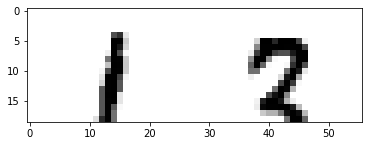

In [6]:
plt.imshow(images_up[20].cpu().numpy().squeeze(), cmap='gray_r')
print(pr_labels[10], pu_labels[10])

In [7]:
from torch import nn

# # # Build a feed-forward network
san1_model = nn.Sequential(nn.Linear(1064, 532),
                      nn.ReLU(),
                      nn.Linear(532, 256),
                      nn.ReLU(),
                      nn.Linear(256, 128))

san2_model = nn.Sequential(nn.Linear(1064, 532),
                      nn.ReLU(),
                      nn.Linear(532, 256),
                      nn.ReLU(),
                      nn.Linear(256, 128))

rec_model = nn. Sequential(nn.Linear(256, 532),
                          nn.ReLU(),
                          nn.Linear(532, 1064),
                          nn.ReLU(),
                          nn.Linear(1064, 1568),
                          nn.LeakyReLU())

pr_model = nn.Sequential(nn.Linear(256, 128),
                         nn.ReLU(),
                        nn.Linear(128, 64),
                        nn.ReLU(),
                        nn.Linear(64, 10),
                        nn.ReLU(),
                        nn.Linear(10, 1),
                        nn.Sigmoid())

pu_model = nn.Sequential(nn.Linear(256, 128),
                         nn.ReLU(),
                        nn.Linear(128, 64),
                        nn.ReLU(),
                        nn.Linear(64, 10),
                        nn.ReLU(),
                        nn.Linear(10, 1),
                        nn.Sigmoid())

# san_model = nn.Sequential(
#             nn.Conv2d(1, 16, 3, stride=2, padding=1),
#             nn.ReLU(),
#             nn.MaxPool2d(2,2),
#             nn.Conv2d(16, 32, 3, stride=2, padding=1),
#             nn.ReLU(),
#             nn.MaxPool2d(2,2),
#             nn.Conv2d(32, 64, 2)
#         )

# pr_model = nn.Sequential(
#             nn.ConvTranspose2d(64, 32, 3),
#             nn.ReLU(),
#             nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
#             nn.ReLU(),
#             nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),
#             nn.ReLU(),
#             nn.Flatten(),
# #             nn.Linear(3136, 1560),
# #             nn.ReLU(),
# #             nn.Linear(1568, 780),
# #             nn.ReLU(),
# #             nn.Linear(780, 256),
# #             nn.ReLU(),
# #             nn.Linear(336, 128),
# #             nn.ReLU(),
#             nn.Linear(192, 64),
#             nn.ReLU(),
#             nn.Linear(64, 10),
#             nn.ReLU(),
#             nn.Linear(10, 1),
#             nn.Sigmoid()
#             )

# pu_model = nn.Sequential(
#             nn.ConvTranspose2d(64, 32, 3),
#             nn.ReLU(),
#             nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
#             nn.ReLU(),
#             nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),
#             nn.ReLU(),
#             nn.Flatten(),
# #             nn.Linear(3136, 1560),
# #             nn.ReLU(),
# #             nn.Linear(3, 780),
# #             nn.ReLU(),
# #             nn.Linear(780, 256),
# #             nn.ReLU(),
# #             nn.Linear(336, 128),
# #             nn.ReLU(),
#             nn.Linear(192, 64),
#             nn.ReLU(),
#             nn.Linear(64, 10),
#             nn.ReLU(),
#             nn.Linear(10, 1),
#             nn.Sigmoid()
#             )

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
san1_model.to(device)
san2_model.to(device)
pr_model.to(device)
pu_model.to(device)
rec_model.to(device)

Sequential(
  (0): Linear(in_features=256, out_features=532, bias=True)
  (1): ReLU()
  (2): Linear(in_features=532, out_features=1064, bias=True)
  (3): ReLU()
  (4): Linear(in_features=1064, out_features=1568, bias=True)
  (5): LeakyReLU(negative_slope=0.01)
)

In [ ]:
pr_optimizer = optim.SGD(pr_model.parameters(), lr=0.0003, momentum=0.9)
pu_optimizer = optim.SGD(pu_model.parameters(), lr=0.0003, momentum=0.9)
rec_optimizer = optim.SGD(rec_model.parameters(), lr=0.0003, momentum=0.9)
san1_optimizer = optim.SGD(san1_model.parameters(), lr=0.0003, momentum=0.9)
san2_optimizer = optim.SGD(san2_model.parameters(), lr=0.0003, momentum=0.9)
criterion = nn.BCEWithLogitsLoss()
rec_criterion = nn.MSELoss()

train_loss_rec = []
train_loss_pr = []
train_loss_pu = []
train_loss_san1 = []
train_loss_san2 = []

time0 = time()
epochs = 500
for e in range(epochs):
    san1_running_loss = 0
    san2_running_loss = 0
    pr_running_loss = 0
    pu_running_loss = 0
    rec_running_loss = 0
    for idx, (images, images_up, images_down, labels, pr_labels, pu_labels)in enumerate(train_loader):
        # Flatten MNIST images into a 784 long vector
        images = images.view(images.size(0), -1)
        images = images.to(device)
        images_up = images_up.view(images_up.size(0), -1)
        images_up = images_up.to(device)
        images_down = images_down.view(images_down.size(0), -1)
        images_down = images_down.to(device)
        labels = labels.to(device)
        labels = labels.type(torch.cuda.FloatTensor)
        labels = labels.view(labels.size(0), -1)
        pr_labels = pr_labels.to(device)
        pr_labels = pr_labels.type(torch.cuda.FloatTensor)
        pr_labels = pr_labels.view(pr_labels.size(0), -1)
        pu_labels = pu_labels.to(device)
        pu_labels = pu_labels.type(torch.cuda.FloatTensor)
        pu_labels = pu_labels.view(pu_labels.size(0), -1)  
        
        # Training pass
        if idx%15 != 0:
            pr_optimizer.zero_grad()
            pu_optimizer.zero_grad()
            rec_optimizer.zero_grad()
        
            san1_output = san1_model(images_up)
            san2_output = san2_model(images_down)
            san_output = torch.cat((san1_output, san2_output), 1)
            
            pr_output = pr_model(san_output)
            pr_loss = criterion(pr_output, pr_labels)
            pr_loss.backward(retain_graph=True)
            
            pu_output = pu_model(san_output)
            pu_loss = criterion(pu_output, pu_labels)
            pu_loss.backward(retain_graph=True)
            
            rec_output = rec_model(san_output)
            rec_loss = rec_criterion(rec_output, images)
            rec_loss.backward()
            
            pr_optimizer.step()
            rec_optimizer.step()
            pu_optimizer.step()
            
            pr_running_loss += pr_loss.item()
            pu_running_loss += pu_loss.item()
            rec_running_loss += rec_loss.item()
            
        if idx%15 == 0:
            san1_optimizer.zero_grad()
            san2_optimizer.zero_grad()
            
            san1_output = san1_model(images_up)
            san2_output = san2_model(images_down)
            san_output = torch.cat((san1_output, san2_output), 1)
            
            pr_output = pr_model(san_output)
            pr_loss = criterion(pr_output, pr_labels)
            pu_output = pu_model(san_output)
            pu_loss = criterion(pu_output, pu_labels)
            rec_output = rec_model(san_output)
            rec_loss = rec_criterion(rec_output, images)
            
            loss = (50*pu_loss +100*rec_loss) - (30*pr_loss)
#             loss = 30*pu_loss - 4*pr_loss
            loss.backward()
            san1_optimizer.step()
            san2_optimizer.step()
        
            san1_running_loss += loss.item()
            san2_running_loss += loss.item()
    else:
        print("Training Epoch {} - San1 loss: {}, San2 loss: {}, Private loss: {}, Public Loss: {}, Recon Loss: {}".format(e, san1_running_loss/len(train_loader), san2_running_loss/len(train_loader), pr_running_loss/len(train_loader), pu_running_loss/len(train_loader), rec_running_loss/len(train_loader)))
    train_loss_rec.append(rec_running_loss/len(train_loader))
    train_loss_pr.append(pr_running_loss/len(train_loader))
    train_loss_pu.append(pu_running_loss/len(train_loader))
    train_loss_san1.append(san1_running_loss/len(train_loader))
    train_loss_san2.append(san2_running_loss/len(train_loader))

print("\nTraining Time (in minutes) =",(time()-time0)/60)

Training Epoch 0 - San1 loss: 1.7374709170797598, San2 loss: 1.7374709170797598, Private loss: 0.6614957070716506, Public Loss: 0.6737236001759844, Recon Loss: 0.09925548180632884
Training Epoch 1 - San1 loss: 1.712898064147481, San2 loss: 1.712898064147481, Private loss: 0.6602342621139858, Public Loss: 0.6717658078731479, Recon Loss: 0.09907831823277047
Training Epoch 2 - San1 loss: 1.7178994127551612, San2 loss: 1.7178994127551612, Private loss: 0.6590584150665556, Public Loss: 0.6694867460014265, Recon Loss: 0.09882946954587536
Training Epoch 3 - San1 loss: 1.70373631743214, San2 loss: 1.70373631743214, Private loss: 0.6580460461051872, Public Loss: 0.6679223030424484, Recon Loss: 0.09854659962151056
Training Epoch 4 - San1 loss: 1.6911261185355808, San2 loss: 1.6911261185355808, Private loss: 0.6568928022518792, Public Loss: 0.6659898343293563, Recon Loss: 0.09839852586807803
Training Epoch 5 - San1 loss: 1.7084917131897128, San2 loss: 1.7084917131897128, Private loss: 0.656338735

In [ ]:
from torchvision.utils import save_image

dir = '5/16-pu&pr'

def make_dir():
    image_dir = dir
    if not os.path.exists(image_dir):
        os.makedirs(image_dir)
make_dir()

def save_decod_img(img, org_img, epoch):
    img = img.view(img.size(0), 1, 28, 56)
    org_img = org_img.view(org_img.size(0), 1, 28, 56)
    save_image(img, dir+'/image_rec{}.png'.format(epoch))
    save_image(org_img, dir+'/image_org{}.png'.format(epoch))

In [ ]:
path = dir+'/model.pth'

torch.save({
        'san_state_dict': san_model.state_dict(),
        'pr_state_dict' : pr_model.state_dict(),
        'pu_state_dict' : pu_model.state_dict(),
#         'rec_state_dict' : rec_model.state_dict(),
        'san_optimizer_state_dict': san_optimizer.state_dict(),
        'pu_optimizer_state_dict' : pu_optimizer.state_dict(),
        'pr_optimizer_state_dict' : pr_optimizer.state_dict(),
#         'rec_optimizer_state_dict' : rec_optimizer.state_dict(),
        'epoch': epochs,
#         'rec_loss': rec_loss,
        'pr_loss' : pr_loss,
        'pu_loss' : pu_loss,
        'san_loss' : loss, 
#         'rec_losses': train_loss_rec,
#         'pr_losses': train_loss_pr,
#         'pu_losses': train_loss_pu, 
#         'san_losses': train_loss_san
        }, path)

Text(0, 0.5, 'Loss')

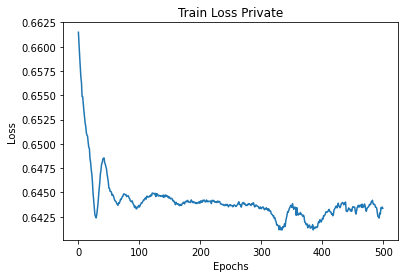

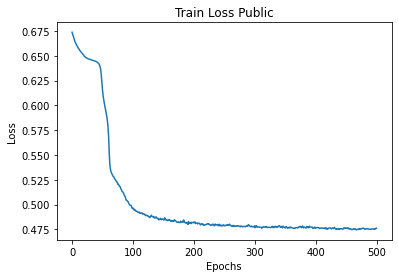

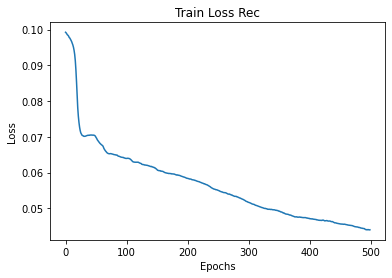

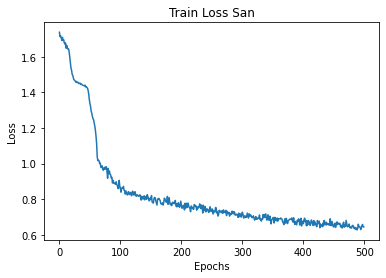

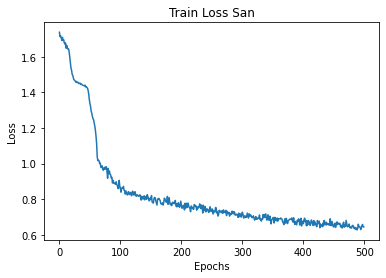

In [16]:
plt.figure()
plt.plot(train_loss_pr)
plt.title('Train Loss Private')
plt.xlabel('Epochs')
plt.ylabel('Loss')
# plt.savefig(dir+'/pr_loss.png')

plt.figure()
plt.plot(train_loss_pu)
plt.title('Train Loss Public')
plt.xlabel('Epochs')
plt.ylabel('Loss')
# plt.savefig(dir+'/pu_loss.png')

plt.figure()
plt.plot(train_loss_rec)
plt.title('Train Loss Rec')
plt.xlabel('Epochs')
plt.ylabel('Loss')
# plt.savefig(dir+'/rec_loss.png')

plt.figure()
plt.plot(train_loss_san1)
plt.title('Train Loss San')
plt.xlabel('Epochs')
plt.ylabel('Loss')
# plt.savefig(dir+'/rec_loss.png')

plt.figure()
plt.plot(train_loss_san2)
plt.title('Train Loss San')
plt.xlabel('Epochs')
plt.ylabel('Loss')

In [17]:
def view_classify(img, ps):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.cpu().data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.cpu().resize_(1, 28, 56).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(1), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(1))
    ax2.set_yticklabels(np.arange(1))
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)
    plt.tight_layout()

Predicted Public label = [1.]
Private model output value =  0.12973922491073608
Predicted Private label = [0.]


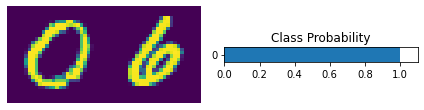

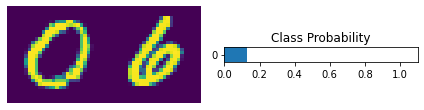

In [18]:
images, images_up, images_down, labels, pr_labels, pu_labels = next(iter(test_loader))
images = images.view(images.shape[0], -1)
images = images.to(device)
images_up = images_up.view(images_up.size(0), -1)
images_up = images_up.to(device)
images_down = images_down.view(images_down.size(0), -1)
images_down = images_down.to(device)
labels = labels.to(device)
labels = labels.type(torch.cuda.FloatTensor)
labels = labels.view(labels.size(0), -1)
pr_labels = pr_labels.to(device)
pr_labels = pr_labels.type(torch.cuda.FloatTensor)
pr_labels = pr_labels.view(pr_labels.size(0), -1)
pu_labels = pu_labels.to(device)
pu_labels = pu_labels.type(torch.cuda.FloatTensor)
pu_labels = pu_labels.view(pu_labels.size(0), -1) 

pu_acc = 0
# Turn off gradients to speed up this part
i = 10
img = images[i].view(1, 1568)
img_up = images_up[i].view(1, 1064)
img_down = images_down[i].view(1, 1064)

with torch.no_grad():
    san1_output = san1_model(img_up)
    san2_output = san2_model(img_down)
    san_output = torch.cat((san1_output, san2_output),1)
    pr_output = pr_model(san_output)
    pr_out = pr_output.reshape(-1).cpu().detach().numpy().round()
    pu_output = pu_model(san_output)
    pu_out = pu_output.reshape(-1).cpu().detach().numpy().round() 
    
print("Predicted Public label =", pu_out)
view_classify(img.view(1, 28, 56), pu_output)
print("Private model output value = ", pr_output.item())
print("Predicted Private label =", pr_out)
view_classify(img.view(1, 28, 56), pr_output)

In [19]:
pr_correct_count, pu_correct_count, all_count = 0, 0, 0
for images,images_up, images_down, labels, pr_labels, pu_labels in test_loader:
    images = images.view(images.shape[0], -1)
    images = images.to(device)
    images_up = images_up.view(images_up.size(0), -1)
    images_up = images_up.to(device)
    images_down = images_down.view(images_down.size(0), -1)
    images_down = images_down.to(device)
    labels = labels.to(device)
    labels = labels.type(torch.cuda.FloatTensor)
    labels = labels.view(labels.size(0), -1)
    pr_labels = pr_labels.to(device)
    pr_labels = pr_labels.type(torch.cuda.FloatTensor)
    pr_labels = pr_labels.view(pr_labels.size(0), -1)
    pu_labels = pu_labels.to(device)
    pu_labels = pu_labels.type(torch.cuda.FloatTensor)
    pu_labels = pu_labels.view(pu_labels.size(0), -1) 
    
    for i in range(len(labels)):
        img_up = images_up[i].view(1, 1064)
        img_down = images_down[i].view(1, 1064)
        # Turn off gradients to speed up this part
        with torch.no_grad():
            san1_output = san1_model(img_up)
            san2_output = san2_model(img_down)
            san_output = torch.cat((san1_output, san2_output), 1)
            
            pr_output = pr_model(san_output)
            pu_output = pu_model(san_output)

        # Output of the network are log-probabilities, need to take exponential for probabilities
        pr_pred_label = pr_output.reshape(-1).cpu().detach().numpy().round()
        pr_true_label = pr_labels.cpu().numpy()[i]
        if (pr_true_label == pr_pred_label):
            pr_correct_count += 1
            
        pu_pred_label = pu_output.reshape(-1).cpu().detach().numpy().round()
        pu_true_label = pu_labels.cpu().numpy()[i]
        if (pu_true_label == pu_pred_label):
            pu_correct_count += 1
            
        all_count += 1

print("Number Of Images Tested =", all_count)
print("\nPrivate Model Accuracy =", (pr_correct_count/all_count))
print("\nPublic Model Accuracy = ", (pu_correct_count/all_count))

Number Of Images Tested = 4999

Private Model Accuracy = 0.5109021804360873

Public Model Accuracy =  0.9741948389677936


RECONSTRUCTION MODEL

In [220]:
rec_model = nn. Sequential(nn.Linear(128, 256),
                          nn.ReLU(),
                          nn.Linear(256, 512),
                          nn.ReLU(),
                          nn.Linear(512, 1024),
                          nn.ReLU(),
                          nn.Linear(1024, 1568),
                          nn.LeakyReLU())

rec_model.to(device)
rec_criterion = nn.MSELoss()
rec_optimizer = optim.SGD(rec_model.parameters(), lr=0.01, momentum=0.9)



In [256]:
epochs = 50 

# san_model.eval()
# rec_model.train()

for e in range(epochs):
    rec_running_loss = 0
    for idx, (images, labels, pr_labels, pu_labels) in enumerate(train_loader):
        # Flatten MNIST images into a 784 long vector
        images = images.view(images.shape[0], -1)
        images = images.to(device)
        
        # Training pass
        rec_optimizer.zero_grad()

        san_output = san_model(images)

        rec_output = rec_model(san_output)
        rec_loss = rec_criterion(rec_output, images)
        rec_loss.backward()
        rec_optimizer.step()

        rec_running_loss += rec_loss.item()
        
            
    else:
        print("Training Epoch {} - Rec loss: {}".format(e, rec_running_loss/len(train_loader)))
        
#     if e % 5 == 0:
#               save_decod_img(rec_output.cpu().data, images.cpu().data, e)
print("\nTraining Time (in minutes) =",(time()-time0)/60)

Training Epoch 0 - Rec loss: 0.057195624508097044
Training Epoch 1 - Rec loss: 0.05701774339217817
Training Epoch 2 - Rec loss: 0.056770883076597965
Training Epoch 3 - Rec loss: 0.056536324088797545
Training Epoch 4 - Rec loss: 0.056490724553804265
Training Epoch 5 - Rec loss: 0.056247511769042295
Training Epoch 6 - Rec loss: 0.05599028579509624
Training Epoch 7 - Rec loss: 0.0561000967536436
Training Epoch 8 - Rec loss: 0.05580484097742516
Training Epoch 9 - Rec loss: 0.05577029188728089
Training Epoch 10 - Rec loss: 0.055603309284390695
Training Epoch 11 - Rec loss: 0.055622692655800554
Training Epoch 12 - Rec loss: 0.0552912936462542
Training Epoch 13 - Rec loss: 0.05528415300314079
Training Epoch 14 - Rec loss: 0.05504463810730926
Training Epoch 15 - Rec loss: 0.05499777013002454
Training Epoch 16 - Rec loss: 0.05487091483934151
Training Epoch 17 - Rec loss: 0.05481001448905681
Training Epoch 18 - Rec loss: 0.05463988080030055
Training Epoch 19 - Rec loss: 0.05447860768117258
Train

In [20]:
def view_image(org_img, rec_img):
    ''' Function for viewing an image and it's predicted classes.
    '''
    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(org_img.cpu().resize_(1, 28, 56).numpy().squeeze())
    ax1.axis('off')
    ax2.imshow(rec_img.cpu().resize(1, 28, 56).numpy().squeeze())
    ax2.axis('off')
    plt.tight_layout()

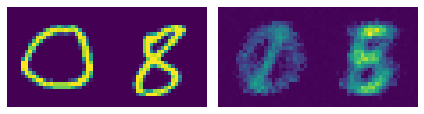

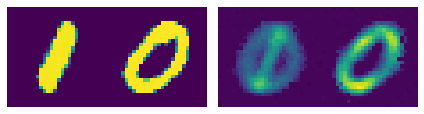

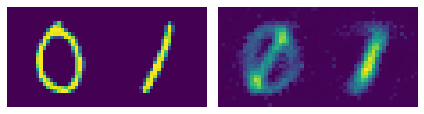

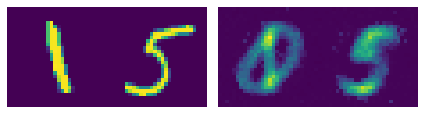

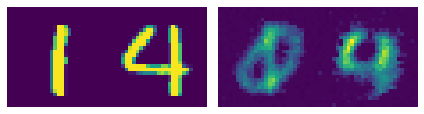

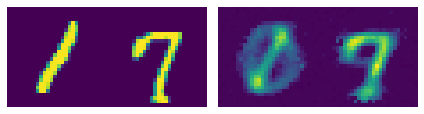

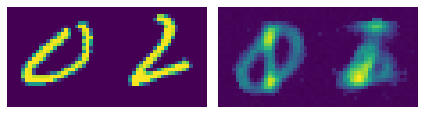

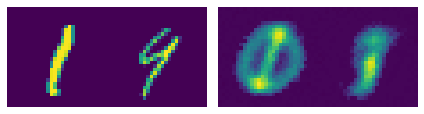

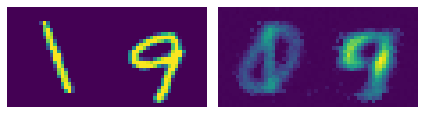

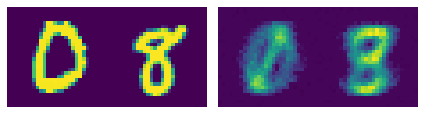

In [21]:
images, images_up, images_down, labels, pr_labels, pu_labels = next(iter(test_loader))
images = images.view(images.shape[0], -1)
images = images.to(device)
images_up = images_up.view(images_up.size(0), -1)
images_up = images_up.to(device)
images_down = images_down.view(images_down.size(0), -1)
images_down = images_down.to(device)

with torch.no_grad():
    for i in range(10):
        img = images[i].view(1, 1568)
        img_up = images_up[i].view(1, 1064)
        img_down = images_down[i].view(1, 1064)
        san1_output = san1_model(img_up)
        san2_output = san2_model(img_down)
        san_output = torch.cat((san1_output, san2_output),1)
        
        rec_output = rec_model(san_output)

        view_image(img.view(1, 28, 56), rec_output.view(1, 28, 56))
#         view_image()

NEW PRIVATE MODEL

In [16]:
new_pr_model = nn.Sequential(nn.Linear(128, 64),
                        nn.ReLU(),
                        nn.Linear(64, 32),
                        nn.ReLU(),
                        nn.Linear(32, 10),
                        nn.ReLU(),
                        nn.Linear(10, 1),
                        nn.Sigmoid())
new_pr_model.to(device)
new_pr_optimizer = optim.SGD(new_pr_model.parameters(), lr=0.001, momentum=0.9)
new_criterion = nn.BCEWithLogitsLoss()


In [18]:
train_loss_new_pr = []

time0 = time()
epochs = 50 #run for 500 epochs; start at random points; change the arch
for e in range(epochs):
    running_loss = 0
    new_pr_running_loss = 0
    for idx, (images, labels, pr_labels, pu_labels)in enumerate(train_loader):
        # Flatten MNIST images into a 784 long vector
        images = images.view(images.size(0), -1)
        images = images.to(device)
        labels = labels.to(device)
        labels = labels.type(torch.cuda.FloatTensor)
        labels = labels.view(labels.size(0), -1)
        pr_labels = pr_labels.to(device)
        pr_labels = pr_labels.type(torch.cuda.FloatTensor)
        pr_labels = pr_labels.view(pr_labels.size(0), -1)
        
        # Training pass
        new_pr_optimizer.zero_grad()

        san_output = san_model(images)

        new_pr_output = new_pr_model(san_output)
        new_pr_loss = criterion(new_pr_output, pr_labels)
        new_pr_loss.backward()
        new_pr_optimizer.step()
        new_pr_running_loss += new_pr_loss.item()
            
    else:
        print("Training Epoch {} - New Private loss: {}".format(e, new_pr_running_loss/len(train_loader)))
    train_loss_pr.append(pr_running_loss/len(train_loader))
print("\nTraining Time (in minutes) =",(time()-time0)/60)

Training Epoch 0 - New Private loss: 0.7032819795029243
Training Epoch 1 - New Private loss: 0.7032818866660223
Training Epoch 2 - New Private loss: 0.7033086957986397
Training Epoch 3 - New Private loss: 0.7033989786187096
Training Epoch 4 - New Private loss: 0.7032533753710939
Training Epoch 5 - New Private loss: 0.7032525505098846
Training Epoch 6 - New Private loss: 0.7032524085105838
Training Epoch 7 - New Private loss: 0.7033065597876869
Training Epoch 8 - New Private loss: 0.7032791079615083
Training Epoch 9 - New Private loss: 0.7032236663429329
Training Epoch 10 - New Private loss: 0.703194494366341
Training Epoch 11 - New Private loss: 0.7033101401060743
Training Epoch 12 - New Private loss: 0.7033086946553282
Training Epoch 13 - New Private loss: 0.7033068242737704
Training Epoch 14 - New Private loss: 0.7031656743010597
Training Epoch 15 - New Private loss: 0.7032827205975037
Training Epoch 16 - New Private loss: 0.7032830186207276
Training Epoch 17 - New Private loss: 0.70

Private model output value =  0.12034203112125397
Predicted Private label = [0.]


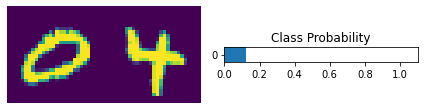

In [25]:
images, labels, pr_labels, pu_labels = next(iter(test_loader))
images = images.view(images.shape[0], -1)
images = images.to(device)
labels = labels.to(device)
labels = labels.type(torch.cuda.FloatTensor)
labels = labels.view(labels.size(0), -1)
pr_labels = pr_labels.to(device)
pr_labels = pr_labels.type(torch.cuda.FloatTensor)
pr_labels = pr_labels.view(pr_labels.size(0), -1)
i = 10
img = images[i].view(1, 1568)

with torch.no_grad():
    san_output = san_model(img)
    pr_output = pr_model(san_output)
    pr_out = pr_output.reshape(-1).cpu().detach().numpy().round()
    
print("Private model output value = ", pr_output.item())
print("Predicted Private label =", pr_out)
view_classify(img.view(1, 28, 56), pr_output)

In [19]:
pr_correct_count, all_count = 0, 0
for images,labels, pr_labels, pu_labels in test_loader:
    images = images.view(images.shape[0], -1)
    images = images.to(device)
    labels = labels.to(device)
    labels = labels.type(torch.cuda.FloatTensor)
    labels = labels.view(labels.size(0), -1)
    pr_labels = pr_labels.to(device)
    pr_labels = pr_labels.type(torch.cuda.FloatTensor)
    pr_labels = pr_labels.view(pr_labels.size(0), -1)
    
    for i in range(len(labels)):
        img = images[i].view(1, 1568)
        # Turn off gradients to speed up this part
        with torch.no_grad():
            san_output = san_model(img)
            pr_output = pr_model(san_output)

        # Output of the network are log-probabilities, need to take exponential for probabilities
        pr_pred_label = pr_output.reshape(-1).cpu().detach().numpy().round()
        pr_true_label = pr_labels.cpu().numpy()[i]
        if (pr_true_label == pr_pred_label):
            pr_correct_count += 1
            
        all_count += 1

print("Number Of Images Tested =", all_count)
print("\nPrivate Model Accuracy =", (pr_correct_count/all_count))

Number Of Images Tested = 4999

Private Model Accuracy = 0.5109021804360873


In [ ]:
Train a new recon

In [28]:
from sklearn.metrics import *
def evaluate(san_model, pr_model, pu_model):
    san_model.eval()
    pr_model.eval()
    pu_model.eval()

    pu_correct = 0 
    pr_correct = 0
    pr_pred_list = []
    pu_pred_list = []
    pr_gt = []
    pu_gt = []
    pu_score = []
    pr_score = []
    
    with torch.no_grad():
        for data in test_loader:
            img, labels, pr_labels, pu_labels = data
            img = img.view(img.size(0), -1)
            img = img.to(device)
            labels = labels.to(device)
            pr_labels = pr_labels.to(device)
            pu_labels = pu_labels.to(device)
            
            san_out = san_model(img)

#             rec_out = rec_model(san_out)
            private_out = pr_model(san_out)
#             print(private_out)
            pr_out = torch.sigmoid(private_out)
#             print(pr_out)
            public_out = pu_model(san_out)
#             print(public_out)
            pu_out = torch.sigmoid(public_out)
#             print(pu_out)
            
            pr_score.extend(pr_out.cpu().numpy())
            pu_score.extend(pu_out.cpu().numpy())
                        
            pr_pred = torch.round(pr_out)
            pr_pred_list.extend(pr_pred.cpu().numpy())
            pu_pred = torch.round(pu_out)
            pu_pred_list.extend(pu_pred.cpu().numpy())
            
            for gt in range(len(pr_labels)):
                
                pr_gt.append(pr_labels[gt].item())
                pu_gt.append(pu_labels[gt].item())
        
    
#     view_image(rec_out[5].view(1, 28, 56), img[5].view(1, 28, 56))
           
    pr_pred_list = [a.squeeze().tolist() for a in pr_pred_list]
    pu_pred_list = [a.squeeze().tolist() for a in pu_pred_list]
        
    return pr_pred_list, pu_pred_list, pr_gt, pu_gt, pr_score, pu_score
pr_pred_list, pu_pred_list, pr_gt, pu_gt, pr_score, pu_score = evaluate(san_model, pr_model, pu_model)

In [29]:
print('Private:')
print(confusion_matrix(pr_gt, pr_pred_list))
print(accuracy_score(pr_gt, pr_pred_list))

print('Public:')
print(confusion_matrix(pu_gt, pu_pred_list))
print(accuracy_score(pu_gt, pu_pred_list))
# print(classification_report(pr_gt, pr_pred_list))

Private:
[[   0 2554]
 [   0 2445]]
0.4890978195639128
Public:
[[2367  167]
 [  17 2448]]
0.9631926385277055


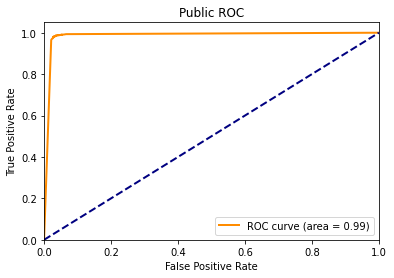

In [30]:
fpr = dict()
tpr = dict()
roc_auc = dict()
# fpr, tpr, t = roc_curve(pu_gt, pu_pred_list)
fpr, tpr, t = roc_curve(pu_gt, pu_score)
roc_auc = auc(fpr, tpr)
# print(fpr, tpr)
# print(t)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Public ROC')
plt.legend(loc="lower right")
plt.show()
# plt.savefig(image_dir+'Pu_ROC.png')

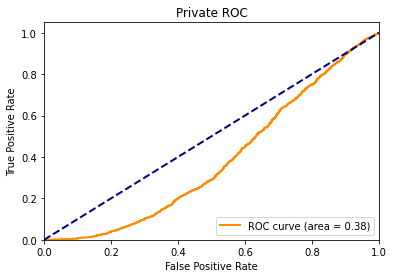

In [31]:
fpr = dict()
tpr = dict()
roc_auc = dict()
# fpr, tpr, t = roc_curve(pu_gt, pu_pred_list)
fpr, tpr, t = roc_curve(pr_gt, pr_score)
roc_auc = auc(fpr, tpr)
# print(fpr, tpr)
# print(t)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Private ROC')
plt.legend(loc="lower right")
plt.show()
# plt.savefig(image_dir+'Pu_ROC.png')